In [1]:
#load the required modules
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import njit, prange
import warnings

In [2]:
np.random.seed(42)

In [3]:
@njit(parallel=True)
def Helium_GS(r, alpha=2.0, ansatz=1):
    """
    Ground state trial wavefunction for the Helium atom.

    Parameters:
    - r: 2x3 array, positions of 2 electrons in 3D.
    - alpha: variational parameter.
    - ansatz: choose 1 or 2 for different trial wavefunctions.

    Returns:
    - psi_T: Trial wavefunction evaluated at r.
    """
    r_comb = 0.0
    for i in prange(r.shape[0]):
        r_electron = np.sqrt(np.sum(r[i]**2))
        r_comb += r_electron

    if ansatz == 1:
        psi_T = np.exp(-alpha * r_comb)

    elif ansatz == 2:
        r12 = np.sqrt(np.sum((r[0] - r[1])**2))  # distance between electrons
        psi_T = np.exp(-alpha * r_comb) * np.exp(r12 / 2.0)

    else:
        psi_T = 0.0  # handle invalid ansatz

    return psi_T


In [4]:
@njit
def He_GSPDF(r, alpha=2, ansatz = 1):
    """
    This function defines the ground state trial
    Probability density function for Helium atom

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    - ansatz: choose 1 or 2 for different wave function
    Returns:
    The trial PDF for the Helium atom
    """

    wave_func = Helium_GS(r, alpha, ansatz)
    return np.abs(wave_func)**2

The central finite difference approximation of the laplacian:

$\frac{\partial^2 \psi}{\partial x^2} \approx \frac{\psi(x+h)+\psi(x-h)-2\psi(x)}{h^2}$

E_{\text{loc}}(\mathbf{r}) = \frac{1}{\psi(\mathbf{r})} \hat{H} \psi(\mathbf{r}) = -\frac{1}{2} \frac{\nabla^2 \psi(\mathbf{r})}{\psi(\mathbf{r})} + V(\mathbf{r})


In [5]:
@njit
def He_loc_en(r, alpha=2, ansatz = 1):
    """
    This function defines the ground state Local energy
    for Helium atom

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)

    Returns:
    The Local energy for the Helium atom
    """
    GS_zero = Helium_GS(r, alpha, ansatz)
    step = 1e-5
    KE = 0.0

    #Performing central difference method for calculation of laplacian
    for i in prange(r.shape[0]):
        for j in range(r.shape[1]):
            #forward jump
            r_plus = np.copy(r)
            r_plus[i][j] += step
            GS_plus = Helium_GS(r_plus, alpha, ansatz)
            #backward jump
            r_minus = np.copy(r)
            r_minus[i][j] -= step
            GS_minus = Helium_GS(r_minus, alpha, ansatz)

            KE += (GS_plus + GS_minus - 2.0 * GS_zero) / step**2

    kinetic = -0.5 * KE / GS_zero

    #Accounting for the electron-nucleus interaction
    PE1 = 0.0
    for i in prange(r.shape[0]):
        r_electron = np.sqrt(np.sum(r[i]**2))
        PE1 += -2.0 / r_electron

    #Accounting for the electron-electron repulsion
    r12 = np.sqrt(np.sum((r[0] - r[1])**2))
    if r12 != 0:
        PE2 = 1.0/r12
    else:
        PE2 = 0

    potential = PE1 + PE2
    local_energy = kinetic + potential
    return local_energy

In [6]:
@njit
def Helium_VMC(r, step, samples=10000, alpha=2, ansatz = 1):
    """
    This function performs Variational Monte Carlo
    method for Helium atom

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)
    - alpha: Optimizing parameter (Default = 2)

    Returns:
    The saved positions and saved energies respectively
    """
    position_saved = []
    energy_saved = []

    for n in prange(samples):
        q = np.random.rand(r.shape[0], r.shape[1])
        r_new = r + step * (q - 0.5) #for symmetry purpose
        P_old = He_GSPDF(r, alpha, ansatz)
        P_new = He_GSPDF(r_new, alpha, ansatz)
        ratio = P_new / (P_old + 1e-10)

        s = np.random.rand()
        if ratio > s:
            r = r_new

        position_saved.append(r.copy())
        energy_saved.append(He_loc_en(r, alpha, ansatz))

    return position_saved, energy_saved

In [7]:
def Helium_alpha_opt(alpha_list, r, step, samples=10000, ansatz=1):
    """
    This function optimizes alpha by performing
    Variational Monte Carlo method on Helium atom

    Parameters:
    - alpha_list: Takes in a list of alpha values for which VMC will be performed
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)

    Returns:
    The saved positions and saved energies respectively
    """
    saved_energies = []
    variance = []
    mean_energies = []

    for a in tqdm(alpha_list, unit='alpha', desc='Optimizing alpha'):
        _, energies = Helium_VMC(r, step, samples, a, ansatz)
        mean_e = np.mean(energies)
        saved_energies.append(mean_e)
        variance.append(np.var(energies))
        mean_energies.append(mean_e)

    optimal_alpha = alpha_list[np.argmin(saved_energies)]
    return saved_energies, optimal_alpha, variance, mean_energies

In [8]:
alpha_range = np.linspace(1, 2.5, 10)
pos_initial = np.random.rand(2, 3)
energies_ans2, optimal_alpha_ans2, variance_ans2, mean_energy_ans2 = Helium_alpha_opt(alpha_range, pos_initial, step=0.15, samples=1000000, ansatz=2)

Optimizing alpha: 100%|██████████| 10/10 [37:14<00:00, 223.49s/alpha]


<ipython-input-9-125f902e0a12>:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(alpha_range, mean_energy_ans2, 'o-', label='Mean Energy', linestyle = '--', color='k')


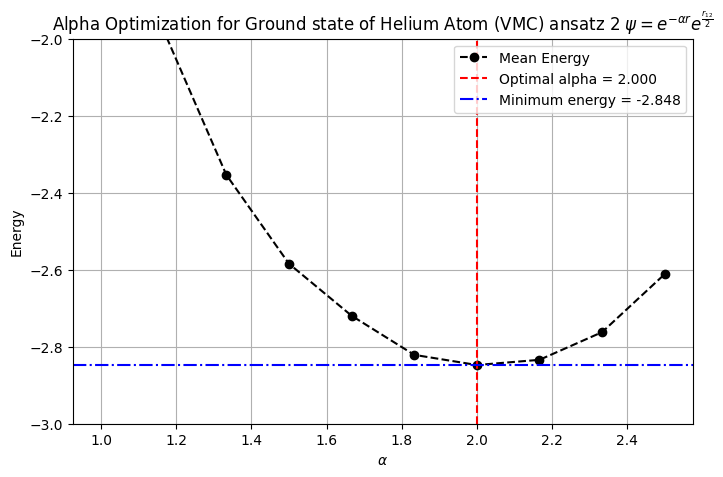

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(alpha_range, mean_energy_ans2, 'o-', label='Mean Energy', linestyle = '--', color='k')
#plt.plot(alpha_range, alpha_range**2-4*alpha_range+(5/8)*alpha_range, linestyle = '-.', label='Exact energy')
plt.axvline(optimal_alpha_ans2, color='r', linestyle='--', label=f'Optimal alpha = {optimal_alpha_ans2:.3f}')
plt.axhline(np.min(mean_energy_ans2), color='b', linestyle = '-.', label=f'Minimum energy = {np.min(mean_energy_ans2):.3f}')
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.title(r'Alpha Optimization for Ground state of Helium Atom (VMC) ansatz 2 $\psi = e^{-\alpha r}e^{\frac{r_{12}}{2}}$')
plt.legend()
plt.grid(True)
plt.ylim(-3,-2.)
plt.show()

In [10]:
from IPython.display import display, Math

display(Math(r"\alpha \quad \quad \quad \quad \langle H \rangle \quad \quad \quad \quad \quad \quad  \sigma^2"))

for i in range(len(alpha_range)):
    print(f"{round(alpha_range[i], 4)}\t{round(mean_energy_ans2[i], 4)}\t \t{round(variance_ans2[i], 4)}")

<IPython.core.display.Math object>

1.0	-1.7094	 	1.0552
1.1667	-1.979	 	1.0507
1.3333	-2.3537	 	1.1396
1.5	-2.5844	 	0.9395
1.6667	-2.7195	 	0.6339
1.8333	-2.8211	 	0.373
2.0	-2.8475	 	0.241
2.1667	-2.834	 	0.4209
2.3333	-2.7622	 	1.1201
2.5	-2.6114	 	2.5765


In [11]:
alpha_range = np.linspace(1, 2, 10)
pos_initial = np.random.rand(2, 3)
energies, optimal_alpha, variance, mean_energy = Helium_alpha_opt(alpha_range, pos_initial, step=0.15, samples=1000000, ansatz=1)

Optimizing alpha: 100%|██████████| 10/10 [19:11<00:00, 115.17s/alpha]


<ipython-input-12-867386570351>:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(alpha_range, mean_energy, 'o-', label='Mean Energy', linestyle = '--', color='k')


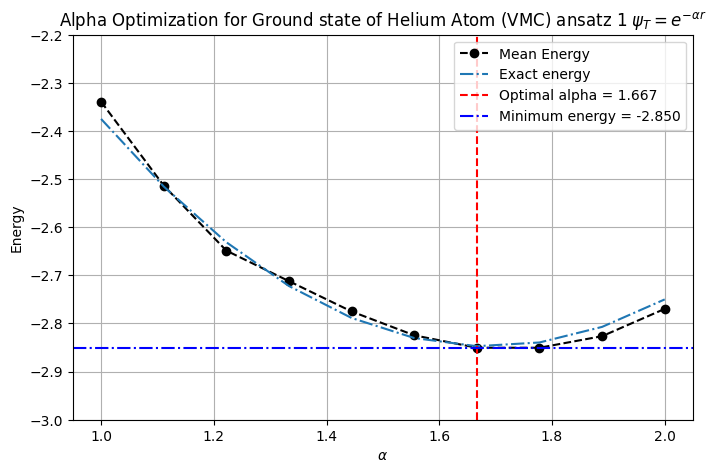

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(alpha_range, mean_energy, 'o-', label='Mean Energy', linestyle = '--', color='k')
plt.plot(alpha_range, alpha_range**2-4*alpha_range+(5/8)*alpha_range, linestyle = '-.', label='Exact energy')
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f'Optimal alpha = {optimal_alpha:.3f}')
plt.axhline(np.min(mean_energy), color='b', linestyle = '-.', label=f'Minimum energy = {np.min(mean_energy):.3f}')
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.title(r'Alpha Optimization for Ground state of Helium Atom (VMC) ansatz 1 $\psi_T = e^{-\alpha r}$')
plt.legend()
plt.grid(True)
plt.ylim(-3,-2.2)
plt.show()

In [13]:
from IPython.display import display, Math

display(Math(r"\alpha \quad \quad \quad \quad \langle H \rangle \quad \quad \quad \quad \quad \quad  \sigma^2"))

for i in range(len(alpha_range)):
    print(f"{round(alpha_range[i], 4)}\t{round(mean_energy[i], 4)}\t \t{round(variance[i], 4)}")

<IPython.core.display.Math object>

1.0	-2.3392	 	1.6245
1.1111	-2.5134	 	1.7471
1.2222	-2.6486	 	1.8213
1.3333	-2.7121	 	1.3957
1.4444	-2.7751	 	1.2559
1.5556	-2.8246	 	1.0971
1.6667	-2.8504	 	0.9423
1.7778	-2.8504	 	0.7809
1.8889	-2.8264	 	0.7752
2.0	-2.7697	 	1.1065
